In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import random

def roll_dices(dices):
    result = 0
    for dice_count, dice_type in dices:
        for i in range(dice_count):
            result += random.randint(1, dice_type)
    return result

def roll_1_type(count, dice_type):
    return roll_dices(((count, dice_type),))

In [227]:
# Return of "make_turn" is:
# ((action1), (action2), ..., response from previous)
# Each (action) is (ActionType, (action response))

class BasicCreature:
    def __init__(self, name, init, max_hp, hp, ac, stats):
        self.name = name
        self.initiative = random.randint(1,20) + init
        self.hp = hp
        self.max_hp = max_hp
        self.temp_hp = 0
        self.ac = ac
        self.stats = stats
        self.states = set()
        self.dead = False
    
    def check_stat(self, stat, challenge):
        check = random.randint(1,20) + self.stats[stat]
        if stat == "Intelligence_save":
            if "minus1d4onIntelligence_save" in self.states:
                self.states.remove("minus1d4onIntelligence_save")
                return check - random.randint(1,4) >= challenge
                
        return check >= challenge
    
    def check_ac(self, attack_throw):
        return (attack_throw < self.get_ac())
    
    def get_hp(self):
        return self.hp
    
    def get_name(self):
        return self.name
    
    def get_initiative(self):
        return self.initiative
    
    def get_ac(self):
        return self.ac
    
    def take_damage(self, damage, dmg_type):
        self.hp = self.hp - damage
        if self.hp <= 0:
            self.dead = True
        return (damage, dmg_type)
    
    def is_dead(self):
        return self.dead
        
    def is_stable(self):
        return "stable" in self.states
    
    def is_unstable(self):
        return "unstable" in self.states
    
    def make_turn(self, enemies, allies):
        if self.is_dead():
            return ("Dead",)
        else:
            return ("Active",)
    
    def choose_enemy(self, enemies):
        max_hp = 0
        target = -1
        for enemy in enemies:
            current_hp = enemy.get_hp()
            if current_hp > max_hp:
                max_hp = current_hp
                target = enemy
        
        return target
    
    def weapon_attack(self, target, modifier, dmg_dice_count, dmg_dice, dmg_mod, dmg_type, advantage=0):
        attack_throw = random.randint(1,20)
        if "prone" in self.states:
            advantage -= 1
            if advantage < -1:
                advantage = -1
        if advantage == 1:
            attack_throw = max(attack_throw, random.randint(1,20))
        elif advantage == -1:
            attack_throw = min(attack_throw, random.randint(1,20))
            
        if attack_throw == 20:
            damage = roll_1_type(2 * dmg_dice_count, dmg_dice) + dmg_mod
            target.take_damage(damage, dmg_type)
            return (target, attack_throw, damage, dmg_type)
        elif attack_throw == 1:
            return (target, attack_throw, "Fail", dmg_type)
        elif not target.check_ac(attack_throw + modifier):
            damage = roll_1_type(dmg_dice_count, dmg_dice) + dmg_mod
            target.take_damage(damage, dmg_type)
            return (target, attack_throw, damage, dmg_type)
        else:
            return (target, attack_throw, "Fail", dmg_type)
        
    def melee_weapon_attack(self, target, modifier, dmg_dice_count, dmg_dice, dmg_mod, dmg_type, advantage=0):
        if "prone" in target.states:
            advantage += 1
            if advantage > 1:
                advantage = 1
        return self.weapon_attack(target, modifier, dmg_dice_count, dmg_dice, dmg_mod, dmg_type, advantage=advantage)

class Character(BasicCreature):
    def __init__(self, name, init, hp, max_hp, ac, stats):
        super().__init__(name, init, hp, max_hp, ac, stats)
        self.death_throws = 0
        self.live_throws = 0
        self.lvl = 2
    
    def make_turn(self, enemies, allies):   
        if "unstable" in self.states:
            ss = random.randint(1,20)
            # print(ss)
            if ss < 10:
                self.death_throws = self.death_throws + 1
            else:
                self.live_throws = self.live_throws + 1
            if ss == 1:
                self.death_throws = self.death_throws + 1
            if ss == 20:
                self.states.remove("unstable")
                self.hp = 1
                self.death_throws = 0
                self.live_throws = 0
                return ("Active", ("Death save throw", ss))
            if self.death_throws > 2:
                self.states.remove("unstable")
                self.dead = True
                self.death_throws = 0
                self.live_throws = 0
                return ("Dead", ("Death save throw", ss))
            if self.live_throws > 2:
                self.states.remove("unstable")
                self.states.add("stable")
                self.death_throws = 0
                self.live_throws = 0
                return ("Stable", ("Death save throw", ss))
            return ("Unstable", ("Death save throw", ss, self.death_throws, self.live_throws))
        elif "stable" in self.states:
            return ("Stable",)
        else:
            return super().make_turn(enemies, allies)
        
    def take_damage(self, damage, dmg_type):
        if "unstable" in self.states and damage > 0:
            self.death_throws = self.death_throws + 1
            if self.death_throws > 2:
                self.dead = True
                return (damage, dmg_type)
        if "stable" in self.states and damage > 0:
            self.states.remove("stable")
            self.states.add("unstable")
            return (damage, dmg_type)
        damage, dmg_type = super().take_damage(damage, dmg_type)
        if self.is_dead():
            if -self.hp >= self.max_hp:
                self.dead = True
            else:
                self.dead = False
                self.hp = 0
                self.states.add("unstable")
                self.states.add("prone")
        return (damage, dmg_type)

    
class Odrimorn(Character):
    def __init__(self):
        super().__init__("Odrimorn", 1, 14, 14, 11, dict({"Constitution_save":2}))
        self.spell_slots = [0, 3, 0, 0, 0, 0, 0, 0, 0, 0] # 1st lvl is spell_slots[1], etc.
        
    def make_turn(self, enemies, allies):
        if "cast:shield" in self.states:
            self.states.remove("cast:shield")
        response = super().make_turn(enemies, allies)
        if response[0] == "Active":
            target = self.choose_enemy(enemies)
            if target == -1:
                return (("Skip", ("Nobody to attack")), response)
            return (("Cast", self.mind_silver(target)), response)
        else:
            return (response,)
    
    def mind_silver(self, target):
        dmg_type = "psychic"
        if not target.check_stat("Intelligence_save", 13):
            damage = random.randint(1,6)
            target.states.add("minus1d4onIntelligence_save")
            target.take_damage(damage, dmg_type)
            return ("Mind Silver", (target, damage, dmg_type))
        else:
            return ("Mind Silver", (target, "Fail", dmg_type))
    
    def take_damage(self, damage, dmg_type):
        return super().take_damage(damage, dmg_type)
    
    def check_ac(self, attack_throw):
        if (not super().check_ac(attack_throw)) and (self.ac + 5 > attack_throw) and (not "cast:shield" in self.states) and self.spell_slots[1] > 0:
            self.states.add("cast:shield")
            self.spell_slots[1] -= 1
        return super().check_ac(attack_throw)
        
    def get_ac(self):
        if "cast:shield" in self.states:
            return self.ac + 5
        else:
            return super().get_ac()
    
    
class Ilukan(Character):
    def __init__(self):
        super().__init__("Ilukan", 1, 22, 22, 16, dict({"Constitution_save":5}))
        self.second_breath = 1
        
    def make_turn(self, enemies, allies):   
        response = super().make_turn(enemies, allies)
        output = []
        if response[0] == "Active":
            if (self.max_hp - self.hp > 10) and self.second_breath > 0:
                self.second_breath -= 1
                prev_hp = self.hp
                self.hp += random.randint(1,10) + self.lvl
                self.hp = min(self.hp, self.max_hp)
                output.append( ("ClassAction", ("Second Breath", ( self.hp - prev_hp, ))) )
                
            target = self.choose_enemy(enemies)
            if target == -1:
                output.append( ("Skip", ("Nobody to attack")) )
            else:
                output.append( ("Attack", self.attack_greatsword(target)) )
            output.append(response)
            return output
        else:
            return (response,)
    
    def attack_greatsword(self, target):
        return ("Greatsword", self.melee_weapon_attack(target, 5, 2, 6, 3, "slashing"))
    
    def take_damage(self, damage, dmg_type):
        return super().take_damage(damage, dmg_type)

    
class Tommy(Character):
    def __init__(self):
        super().__init__("Tommy", 3, 17, 17, 15, dict({"Constitution_save":2}))
        
    def make_turn(self, enemies, allies):   
        response = super().make_turn(enemies, allies)
        if response[0] == "Active":
            target = self.choose_enemy(enemies)
            if target == -1:
                return (("Skip", ("Nobody to attack")), response)
            return (*self.attack_two_shortswords(target), response)
        else:
            return (response,)
    
    def attack_two_shortswords(self, target):
        right_hand = self.melee_weapon_attack(target, 5, 2, 6, 3, "piercing")
        if right_hand[2] != "Fail":
            left_hand = self.melee_weapon_attack(target, 5, 1, 6, 0, "piercing")
            response = ( ("Attack", ("Shortsword_sneaky", right_hand)), ("Attack", ("Shortsword", left_hand)) )
        else:
            left_hand = self.melee_weapon_attack(target, 5, 2, 6, 0, "piercing")
            if left_hand[2] != "Fail":
                response = ( ("Attack", ("Shortsword", right_hand)), ("Attack", ("Shortsword_sneaky", left_hand)) )
            else:
                response = ( ("Attack", ("Shortsword", right_hand)), ("Attack", ("Shortsword", left_hand)) )
        return response
    
    def take_damage(self, damage, dmg_type):
        return super().take_damage(damage, dmg_type)
 


class EnemyCreature(BasicCreature):
   # def __init__(self, name, init, hp, max_hp, ac, stats):
   #     super().__init__(name, init, hp, max_hp, ac, stats)
        
    def choose_enemy(self, enemies, **params):
        max_hp = 0
        target = -1
        if enemies:
            target = max(enemies, key=lambda enemy: self.estimate_danger(enemy, **params))
        
        return target
    
    def estimate_danger(self, target, **params):
        if target.get_hp() <= 0:
            return -100
        if "OTI" in params:
            if type(target) is Odrimorn:
                return 300
            elif type(target) is Tommy:
                return 200
            elif type(target) is Ilukan:
                return 100
            else:
                return 0
            
        if "TOI" in params:
            if type(target) is Odrimorn:
                return 200
            elif type(target) is Tommy:
                return 300
            elif type(target) is Ilukan:
                return 100
            else:
                return 0
            
        else:
            return target.get_hp()/(20-target.get_ac()+params["attack_modifier"]+1)


class Skeleton(EnemyCreature):
    def __init__(self):
        super().__init__("Skeleton", 2, 13, 13, 13, dict({"Constitution_save":2,"Intelligence_save":-2}))
        
    def make_turn(self, enemies, allies):
        response = super().make_turn(enemies, allies)
        if response[0] == "Active":
            target = self.choose_enemy(enemies, attack_modifier=4, TOI=True)
            if target == -1:
                return (("Skip", ("Nobody to attack")), response)
            return (("Attack", self.attack_shortsword(target)), response)
        else:
            return (response,)
        
    def attack_shortsword(self, target):
        return ("Shortsword", self.melee_weapon_attack(target, 4, 1, 6, 2, "piercing"))
    
    def take_damage(self, damage, dmg_type):
        if dmg_type == "poison":
            damage = 0
        if dmg_type == "bludgeoning":
            damage = damage * 2
        return super().take_damage(damage, dmg_type)
        

In [228]:
class Logger:
    def __init__(self, name=""):
        self.name = name
        
    def log_str(self, *string):
        print(*string)
        
class DefaultParser:
    def __init__(self):
        pass
    
    def parse_response(self, response, wrapper):
        if "Active" in response[-1]:
            if len(response[-1]) > 1:
                if response[-1][1] == ("Death save throw", 20):
                    return "Overcomes death, stand up and... " + self.parse_response(response[:-1], wrapper)
            response = response[:-1]
        output = ""
        first = True
        for action in response:
            if first:
                output = str(self.parse_action(action, wrapper))
                first = False
            else:
                output = output + "\nThen " + str(self.parse_action(action, wrapper))
        return output
            
    def parse_action(self, action, wrapper):
        if action[0] == "Attack":
            if action[1][1][2] == "Fail":
                return "Fails to attack {name} with {weapon} by pure attack throw {atkthr}".format(name=wrapper.get_name(action[1][1][0]),
                                                                    weapon = action[1][0],
                                                                    atkthr = action[1][1][1])
            else:
                return "Attacks {name} with {weapon} by pure attack throw {atkthr} \
and dealing {damage} {dmg_type} damage.".format(name=wrapper.get_name(action[1][1][0]),
                                                                    weapon = action[1][0],
                                                                    atkthr = action[1][1][1],
                                                                    damage = action[1][1][2],
                                                                    dmg_type = action[1][1][3])
        elif action[0] == "Cast":
            if action[1][1][1] == "Fail":
                return "Fails to cast {spell} on {name}.".format(name=wrapper.get_name(action[1][1][0]),
                                                                    spell = action[1][0])
            else:
                return "Casts {spell} on {name} dealing {damage} {dmg_type} damage.".format(name=wrapper.get_name(action[1][1][0]),
                                                                    spell = action[1][0],
                                                                    damage = action[1][1][1],
                                                                    dmg_type = action[1][1][2])
        elif action[0] == "Stable":
            return "Is stable and chills."
        elif action[0] == "Unstable":
            return "Is unstable and performs death throw {dth} and now has {f} fails and {s} successes".format(dth = action[1][1],
                                                                                                               f = action[1][2],
                                                                                                               s = action[1][3])
        elif action[0] == "Dead":
            if len(action) > 1:
                if action[1][0] == "Death save throw":
                    return "Finally dies with death saving throw {dth}.".format(dth = action[1][1])
            return "Finally dies."
        elif action[0] == "Skip":
            return "Skips his turn due to {reason}".format(reason = action[1][0])
        elif action[0] == "ClassAction":
            if action[1][0] == "Second Breath":
                return "Got a Second Wind and heals {heal} hp.".format(heal=action[1][1][0])
        elif action[0] == "Active":
            return ""
        else:
            return action

In [229]:
class BattleWrapper:
    def __init__(self, enemies, logging=False, logger=None, parser=None):
        self.enemies = enemies
        self.party = [Odrimorn(), Ilukan(), Tommy()]
        self.creatures = self.enemies + self.party
        self.creatures.sort(key=lambda creature: creature.get_initiative(), reverse=True)
        self.counter = 0
        self.rounds = 0
        self.creatures_num = len(self.creatures)
        self.enemies_dead = []
        self.party_dead = []
        self.marks = {}
        self.logging = logging
        if self.logging:
            if not logger:
                self.logger = Logger(name="Battle")
            else:
                self.logger = logger
            self.mark_enemies()
            
        if not parser:
            self.parser = DefaultParser()
        else:
            self.parser = parser
        
    def mark_enemies(self, mark_single=False):
        count = {}
        for enemy in self.enemies:
            if enemy.get_name() in count:
                count[enemy.get_name()] += 1
            else:
                count[enemy.get_name()] = 1
            self.marks[enemy] = str(count[enemy.get_name()])
        if not mark_single:
            for cr, mrk in dict(self.marks).items():
                if count[cr.get_name()] == 1:
                    del self.marks[cr]
        
    def perform_turn(self):
        current_creature = self.creatures[self.counter]
        if current_creature in self.party:
            response = current_creature.make_turn(self.enemies, self.party)
            if response[0][0] == "Dead":
                self.party.remove(current_creature)
                self.creatures.remove(current_creature)
                self.party_dead.append(current_creature)
        elif current_creature in self.enemies:
            response = current_creature.make_turn(self.party, self.enemies)
            if response[0][0] == "Dead":
                self.enemies.remove(current_creature)
                self.creatures.remove(current_creature)
                self.enemies_dead.append(current_creature)
        else:
            print("[WARNING] Current creature {creature} is neither in party nor enemy team.".format(creature=current_creature))
        
        if self.logging:
            self.logger.log_str("[Round {rnd}, turn {turn}][{name}] ".format(
                                    rnd=self.rounds, turn=self.counter, name=self.get_name(current_creature)),
                                    self.parser.parse_response(response, self))
        
        if len(self.creatures) < self.creatures_num:
            self.creatures_num -= 1
            if self.creatures_num != len(self.creatures):
                print("[WARNING] Something went wrong in creature counting")
        else:
            if self.creatures[self.counter] != current_creature:
                print("[WARNING] Something went wrong in creature turns")
            self.counter += 1
            
        if self.counter >= self.creatures_num:
            self.counter = 0
            self.rounds += 1
            
        return self.check_win() == "Continue"
    
    def perform_battle(self):
        if self.logging:    
            self.log_turn_order(self.logger)
        
        cnt = True
        while cnt:
            cnt = self.perform_turn()
        result = 0
        if self.check_win() == "Win":
            result = 1
            
        if self.logging:
            self.logger.log_str("\nBattle ended with the following result: {}\n".format(self.check_win()))  
            self.log_hps()
        
#         if result == 0:
#             # Enemies left
#             if self.logging:    
#                 self.logger.log_str("\n Enemies left and characters throw death saves \n-----------------------------------------------")
            
#             for enemy in self.enemies:
#                 self.creatures.remove(enemy)
#             self.counter = 0
#             self.creatures_num = len(self.creatures)
#             for i in range(3*5):
#                 self.perform_turn()
    
        return {"Battle_result": result, "Dead_characters": self.party_dead, "Stable_characters":self.party}
    
    def check_win(self):
        if len(self.enemies) == 0:
            return "Win"
        elif len(self.party) == 0:
            return "Lose"
        else:
            all_prone = True
            for char in self.party:
                if not char.is_stable():
                    all_prone = False
            if all_prone:
                return "Lose"
            else:
                return "Continue"
            
    def get_name(self, creature):
        if creature in self.marks:
            return creature.get_name() + "_" + self.marks[creature]
        else:
            return creature.get_name()
    
    def log_turn_order(self, logger):
        logger.log_str("Turn order:\n--------------------------")
        for creature in self.creatures:
            logger.log_str("{name:<20} - {initiative:>2}".format(name=self.get_name(creature), initiative=creature.get_initiative()))

    def log_hps(self, logger=None):
        if not logger:
            if self.logging:
                logger = self.logger
            else:
                print("[ERROR] No logger provided for wrapper without logging")
                return -1
                
        logger.log_str("Players alive:")
        for creature in self.party:
            if creature.is_stable():
                logger.log_str("{name} is stable".format(name=self.get_name(creature)))
            elif creature.is_unstable():
                logger.log_str("{name} is unstable".format(name=self.get_name(creature)))
            else:
                logger.log_str("{name} is {hp} HP".format(name=self.get_name(creature), hp=creature.get_hp()))
        logger.log_str("Enemies alive:")
        for creature in self.enemies:
            logger.log_str("{name} is {hp} HP".format(name=self.get_name(creature), hp=creature.get_hp()))
        logger.log_str("-------------------------------")
        logger.log_str("Players dead:")
        for creature in self.party_dead:
            logger.log_str("{name} is dead".format(name=self.get_name(creature), hp=creature.get_hp()))
        logger.log_str("Enemies dead:")
        for creature in self.enemies_dead:
            logger.log_str("{name} is dead".format(name=self.get_name(creature), hp=creature.get_hp()))

In [231]:
wrp = BattleWrapper([Skeleton(),Skeleton(),Skeleton(),Skeleton(),Skeleton()], logging=True)
wrp.perform_battle()

Turn order:
--------------------------
Skeleton_2           - 22
Skeleton_4           - 12
Tommy                - 12
Skeleton_1           -  9
Ilukan               -  8
Skeleton_5           -  7
Skeleton_3           -  4
Odrimorn             -  4
[Round 0, turn 0][Skeleton_2]  Fails to attack Tommy with Shortsword by pure attack throw 4
[Round 0, turn 1][Skeleton_4]  Fails to attack Tommy with Shortsword by pure attack throw 2
[Round 0, turn 2][Tommy]  Fails to attack Skeleton_1 with Shortsword by pure attack throw 7
Then Fails to attack Skeleton_1 with Shortsword by pure attack throw 1
[Round 0, turn 3][Skeleton_1]  Fails to attack Tommy with Shortsword by pure attack throw 3
[Round 0, turn 4][Ilukan]  Attacks Skeleton_1 with Greatsword by pure attack throw 20 and dealing 11 slashing damage.
[Round 0, turn 5][Skeleton_5]  Fails to attack Tommy with Shortsword by pure attack throw 10
[Round 0, turn 6][Skeleton_3]  Fails to attack Tommy with Shortsword by pure attack throw 4
[Round 0, t

{'Battle_result': 0,
 'Dead_characters': [<__main__.Odrimorn at 0x1bb592e7ee0>,
 'Stable_characters': []}

In [232]:
N = 10000
res = []
for i in range(N):
    wrp = BattleWrapper([Skeleton(),Skeleton(),Skeleton(),Skeleton(),Skeleton()])
    res.append(wrp.perform_battle()['Battle_result'])
W = np.sum(res)

In [233]:
print("Win is likely {}%".format(100*W/N))

Win is likely 37.24%


In [234]:
chances = []
N = 10000
for n_skeletons in range(10):
    res = 0
    for k in range(N):
        enemies = []
        for j in range(n_skeletons):
            enemies.append(Skeleton())
        wrp = BattleWrapper(enemies)
        res += wrp.perform_battle()['Battle_result']
    chances.append(res/N)

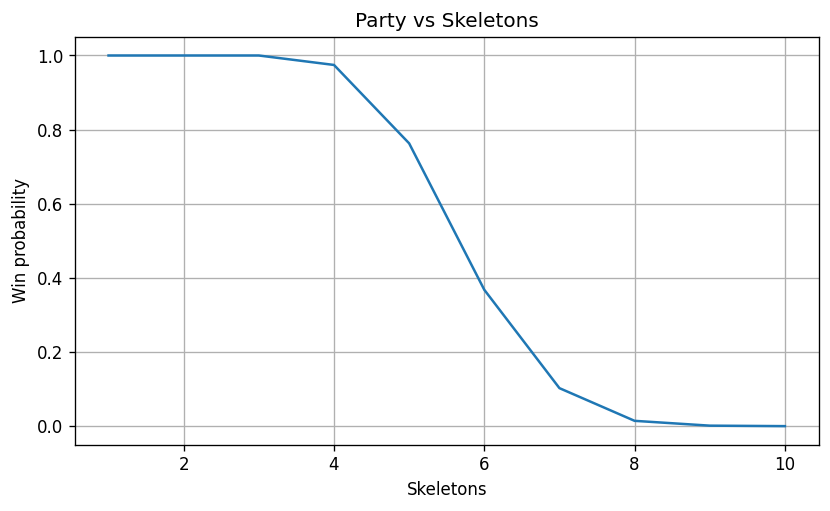

In [235]:
plt.figure(figsize=(8,4.5), dpi=120)
plt.plot(np.arange(1,11),chances)
plt.xlabel("Skeletons")
plt.ylabel("Win probability")
plt.title("Party vs Skeletons")
plt.grid(True)

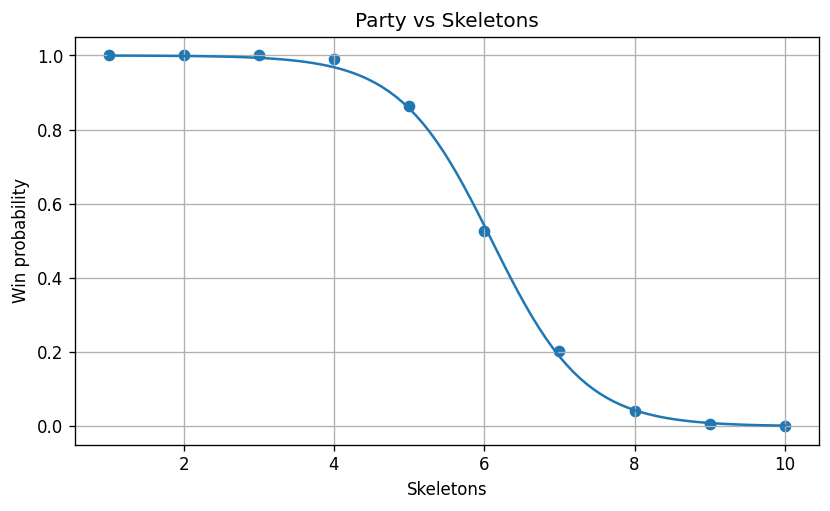

In [224]:
from scipy.optimize import curve_fit

def FD(x, xF, T):
    return 1 / (1 + np.exp( (x - xF) / T ))

params, covM = curve_fit(FD, np.arange(1,11), chances, [6, 2])

x_th = np.linspace(1.,10., 100)
y_th = FD(x_th, *params)

plt.figure(figsize=(8,4.5), dpi=120)
plt.scatter(np.arange(1,11),chances)
plt.plot(x_th, y_th)
plt.xlabel("Skeletons")
plt.ylabel("Win probability")
plt.title("Party vs Skeletons")
plt.grid(True)

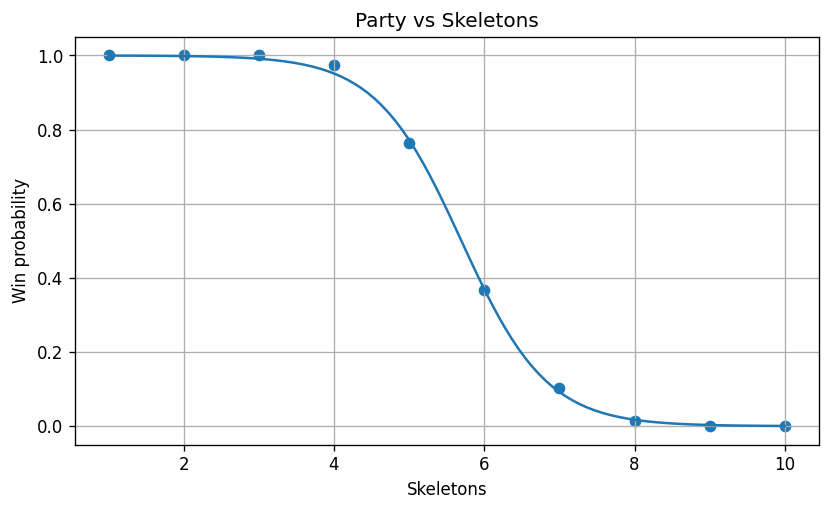

In [236]:
from scipy.optimize import curve_fit

def FD(x, xF, T):
    return 1 / (1 + np.exp( (x - xF) / T ))

params, covM = curve_fit(FD, np.arange(1,11), chances, [6, 2])

x_th = np.linspace(1.,10., 100)
y_th = FD(x_th, *params)

plt.figure(figsize=(8,4.5), dpi=120)
plt.scatter(np.arange(1,11),chances)
plt.plot(x_th, y_th)
plt.xlabel("Skeletons")
plt.ylabel("Win probability")
plt.title("Party vs Skeletons")
plt.grid(True)

In [237]:
params

array([5.69538086, 0.56982419])